In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import matplotlib.dates as mdates
from datetime import datetime
import matplotlib.patches as mpatches
from datetime import datetime, timedelta
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras

# Pipeline to visualize the data

In [13]:
def norm_df(df):
	month_idx = {12:0, 10:1, 11:2, 1:3, 9:4, 7:5, 8:6, 2:7, 6:8, 3:9, 4:10, 5:11}
	hour_idx= {7:0, 6:1, 8:2, 5:3, 4:4, 3:5, 9:6, 2:7, 1:8, 0:9, 23:10, 22:11, 21:12, 10:13, 20:14, 19:15, 11:16, 18:17, 12:18, 17:19, 16:20, 13:21, 15:22, 14:23 }

	df["month_idx"] = df["month"].map(month_idx)
	df["hour_idx"] = df["hour"].map(hour_idx)
	df = df.drop(columns=['month', 'hour'])
	df = df.rename(columns={'hour_idx': 'hour', 'month_idx':'month' })
	nuevoScaler = MinMaxScaler()
	#Obtenemos los nuevos escalers
	nuevoScaler.fit(df[["CO", "NO", "NOX", "NO2", "O3", "PM10", "PM25", "RH", "SO2", "TMP", "WDR", "WSP", "month", "hour"]])
	df_norm_data_escalada = df.copy()
	#Obtener los nuevos valores escalados
	df_norm_data_escalada[["CO", "NO", "NOX", "NO2", "O3", "PM10", "PM25", "RH", "SO2", "TMP", "WDR", "WSP", "month", "hour"]] = nuevoScaler.transform(df[["CO", "NO", "NOX", "NO2", "O3", "PM10", "PM25", "RH", "SO2", "TMP", "WDR", "WSP","month", "hour"]])
	df_norm_data_escalada[['CO', 'NO', 'NOX', 'NO2', 'O3', 'PM10', 'PM25', 'RH', 'SO2','TMP', 'WDR', 'WSP', "month", "hour"]] = df_norm_data_escalada[['CO', 'NO', 'NOX', 'NO2', 'O3', 'PM10', 'PM25', 'RH', 'SO2','TMP', 'WDR', 'WSP', "month", "hour"]].round(12)
	return df_norm_data_escalada, nuevoScaler

In [2]:
def plot_pollutant(dates, X, category_limits, variable, yvariable, dates_limits, stations):

	fechas_datetime = [datetime.strptime(date, '%Y-%m-%d %H:%M') for date in dates]
	category_labels = ['Good', 'Moderate', 'Unhealthy', 'Very Unhealthy', 'Hazardous']   
	colors = ['#9ACA3C', '#F7EC0F', '#F8991F', '#ED2124', '#7D287D', '#7E0023'] 
	colors = colors[0:len(category_limits)-1]
	category_labels = category_labels[0:len(category_limits)-1]
	fig, ax = plt.subplots(figsize=(16, 6))
	#variable = variable +' values'
	plot_colors = ['b','r','k','m', 'c', 'brown', 'purple', 'gray', 'pink', 'olive']
	for i in range(len(X)):
		ax.plot(fechas_datetime, X[i], marker = 'o', markersize=2, label=stations[i], linewidth=.6, color=plot_colors[i])
		
	for limit in category_limits:
		ax.axhline(y=limit, color='gray', linestyle='--', linewidth=0.4)

	for i in range(len(category_limits)-1):
		ax.axhspan(category_limits[i], category_limits[i + 1], color=colors[i], alpha=0.3)


	# Fix date format
	plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))
	category_patches = [mpatches.Patch(color=colors[i], label=category_labels[i]) for i in range(len(colors))]

	# Turn the dates labels
	plt.gcf().autofmt_xdate()
	dates_labels = ["Before", "Cont.\nstarts", "Cont.\nends", "After Cont."]
	if len(dates_limits) > 0:
		for idx,date in enumerate(dates_limits):
			plt.axvline(x=date, color='k', linestyle='--', linewidth=1, label="Vertical Line")
			plt.text(date, 190, dates_labels[idx], color='r', fontsize=12, verticalalignment='center', bbox={'facecolor':'white'})

	plt.xlabel('Timestamp (date, hour and minute)')
	yvariable ='Pollutant Value (' + yvariable+')'
	plt.ylabel(yvariable)
	title1 = variable + ' ​​before, during and after the contingency days'
	plt.title(title1)
	stations_label = [plt.Line2D([0], [0], color=plot_colors[i], marker='o', label=stations[i]) for i in range(len(stations))]
	#[plt.Line2D([0], [0], marker='o', label='MER')]+ [plt.Line2D([0], [0], marker='o', label='PED')]
	#plt.legend(handles=category_patches +stations_label , loc= 'upper right')
	# (1, 1)
	ax.legend(handles=category_patches +stations_label , loc="upper left", bbox_to_anchor=(1.05, 0.75))
	plt.grid(True)
	plt.show()

In [3]:
def plot_values(df_bymonth, df_byhour, varXmonth, varXhour):
	fig, axes = plt.subplots(2, 3, figsize=(16, 5))
	axes[0, 0].scatter(df_bymonth[varXmonth],df_bymonth.O3)
	axes[0, 0].set_ylabel(r'O$_3$')
	axes[0, 0].set_xlabel("Month of the year")
	axes[0, 0].grid(axis="y", linestyle="--", alpha=0.7)

	axes[0, 1].scatter(df_bymonth[varXmonth],df_bymonth.TMP)
	axes[0, 1].set_ylabel("Temperature")
	axes[0, 1].set_xlabel("Month of the year")
	axes[0, 1].grid(axis="y", linestyle="--", alpha=0.7)

	axes[0, 2].plot(df_bymonth[varXmonth],df_bymonth.O3, label=r'O$_3$', color='r')  
	axes[0, 2].plot(df_bymonth[varXmonth],df_bymonth.TMP, label="Temperature", color='b')
	axes[0, 2].legend()  # Add legend
	axes[0, 2].set_ylabel("Values normalized")
	axes[0, 2].set_xlabel("Month of the year")

	axes[1, 0].scatter(df_byhour[varXhour],df_byhour.O3)
	axes[1, 0].set_ylabel(r'O$_3$')
	axes[1, 0].set_xlabel("Hour of the day")
	axes[1, 0].grid(axis="y", linestyle="--", alpha=0.7)

	axes[1, 1].scatter(df_byhour[varXhour],df_byhour.TMP)
	axes[1, 1].set_ylabel("Temperature")
	axes[1, 1].set_xlabel("Hour of the day")
	axes[1, 1].grid(axis="y", linestyle="--", alpha=0.7)

	axes[1, 2].plot(df_byhour[varXhour],df_byhour.O3, label=r'O$_3$', color='r') 
	axes[1, 2].plot(df_byhour[varXhour],df_byhour.TMP, label="Temperature", color='b') 
	axes[1, 2].legend()  # Add legend
	axes[1, 2].set_ylabel("Values normalized")
	axes[1, 2].set_xlabel("Hour of the day")
	axes[1, 2].grid(axis="y", linestyle="--", alpha=0.7)

	# Titles for each subplot (optional)
	axes[0, 0].set_title('Ozone vs month of the year 2024')
	axes[0, 1].set_title('Temperature vs month of the year 2024')
	axes[0, 2].set_title('Tmp&Ozone vs month of the year')
	axes[1, 0].set_title('Ozone vs hour of the day')
	axes[1, 1].set_title('Temperature vs hour of the day')

	plt.tight_layout()
	plt.show()

In [ ]:
stations = ['ACO', 'AJU', 'ARA', 'ATI', 'AZC', 'CAM', 'CCA', 'CES',
       'MON', 'CHO', 'COY', 'CUA', 'CUT', 'FAC', 'HGM', 'IMP', 'IZT', 'LAG',
       'LLA', 'LPR', 'MER', 'NEZ', 'PED', 'PLA', 'SAG', 'SFE', 'SJA', 'SUR',
       'TAC', 'TAH', 'TAX', 'TEC', 'TLA', 'TLI', 'TPN', 'UAX', 'UIZ', 'VAL',
       'VIF', 'XAL', 'AJM', 'BJU', 'FAR', 'GAM', 'INN', 'MGH', 'MPA', 'SAC']

2023-09-23 00:00 2024-09-22 23:00
BJU 2015-08-01 00:00 2024-12-11 15:00
len after the time cut 8784
datetime_f       0
CO            1390
NO            8230
NOX           8784
NO2           1266
O3            1045
PM10          1977
PM25          2031
RH            2201
SO2           3170
TMP           2259
WDR           1767
WSP           1997
dtype: int64
% of missing values 11.896630236794172
Season: winter 1873 no. of rows to test: 187.3 no. in days: 7.8
Season: spring 2104 no. of rows to test: 210.4 no. in days: 8.77
Season: summer 1821 no. of rows to test: 182.1 no. in days: 7.59
Season: autumn 1941 no. of rows to test: 194.1 no. in days: 8.09




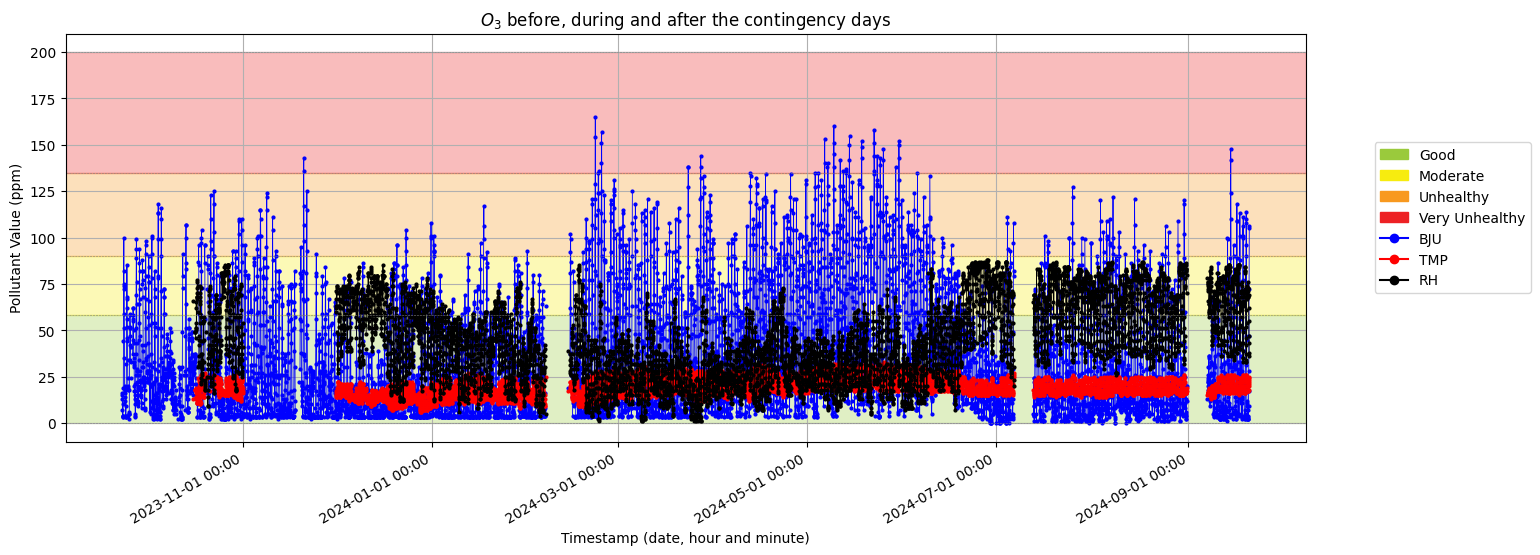

MER 2005-01-01 00:00 2024-12-31 23:00
len after the time cut 8784
datetime_f       0
CO            1099
NO            1154
NOX           1107
NO2           1107
O3             731
PM10          1903
PM25          1964
RH            1399
SO2           1891
TMP           1399
WDR           1461
WSP           1641
dtype: int64
% of missing values 8.321948998178506
Season: winter 1974 no. of rows to test: 197.4 no. in days: 8.22
Season: spring 2001 no. of rows to test: 200.1 no. in days: 8.34
Season: summer 2157 no. of rows to test: 215.7 no. in days: 8.99
Season: autumn 1921 no. of rows to test: 192.1 no. in days: 8.0




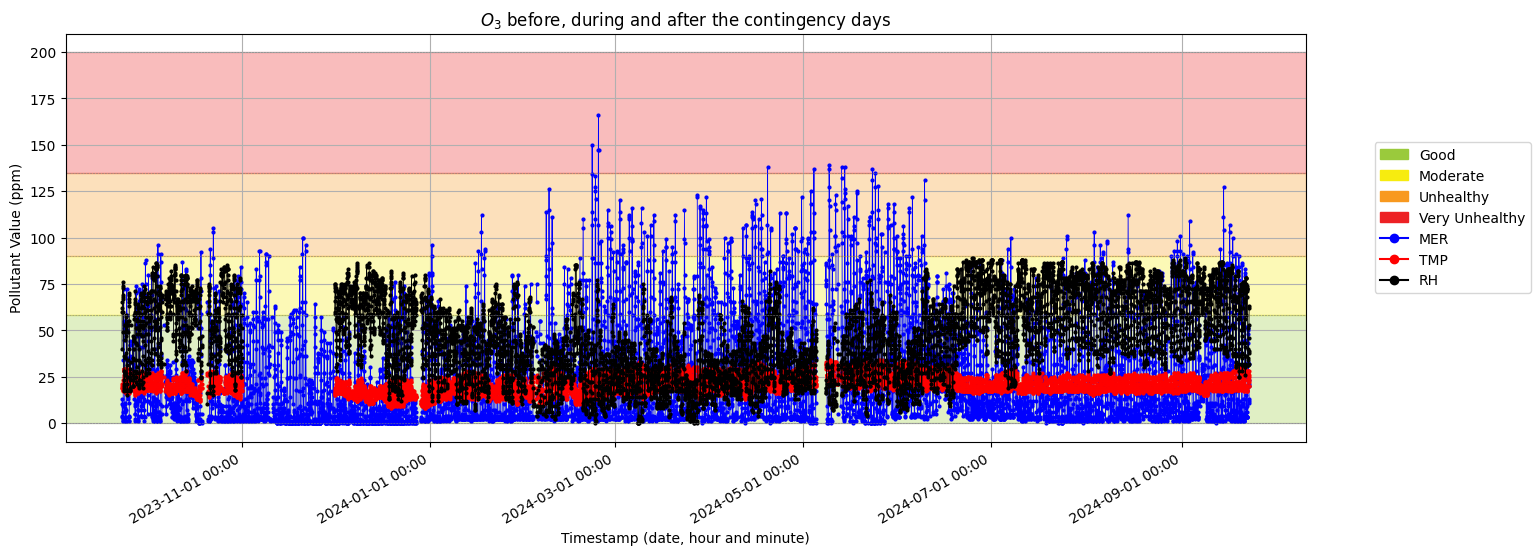

UIZ 2005-01-01 00:00 2024-12-31 23:00
len after the time cut 8784
datetime_f       0
CO            1742
NO            1827
NOX           1826
NO2           1839
O3            1070
PM10          2574
PM25          2910
RH            3658
SO2           3307
TMP           3067
WDR           2646
WSP           3410
dtype: int64
% of missing values 12.181238615664846
Season: winter 2044 no. of rows to test: 204.4 no. in days: 8.52
Season: spring 1991 no. of rows to test: 199.1 no. in days: 8.3
Season: summer 1776 no. of rows to test: 177.6 no. in days: 7.4
Season: autumn 1903 no. of rows to test: 190.3 no. in days: 7.93




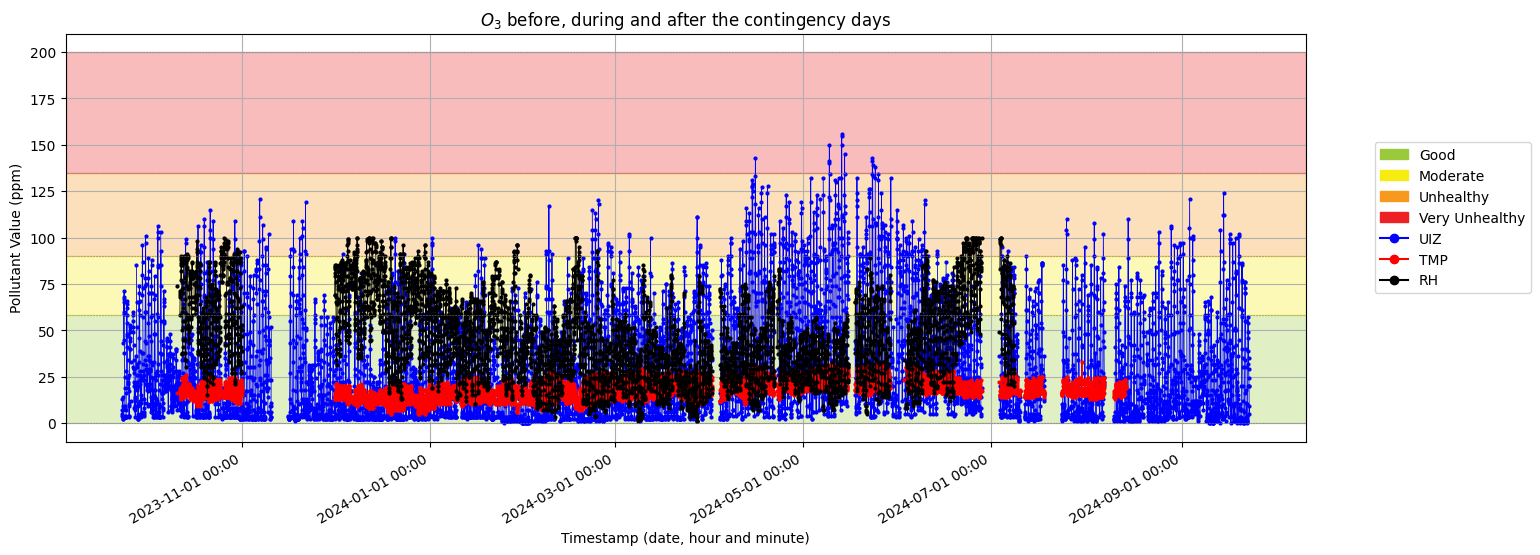

In [14]:
stations = ["MER","PED", "TLA", "UIZ", "AJM"]
estaciones = ["BJU", "MER", "PED", "CAM", "CCA", "UAX", "UIZ", "GAM", "TLA", "VIF", "ATI", "AJM", "SAC"] #  These are the stations that had turn on the env. contingency on 2024
#estaciones = ["AJM", "BJU",  "CAM", "MER", "PED", "UAX", "UIZ", "TLA", "VIF", "SAC" ] #  From the stations above, this are the ones that we have traffic data (tom tom and Here)
stations = ["BJU",  "CAM", "MER", "UIZ", "HGM"] #  From the stations above, this are the ones that we have traffic data (only HERE) "MCM" only measure pH and Atmospheric deposition
# "HGM" has a lot of missing values, In second place is CAM
stations = ["BJU", "MER", "UIZ"] #  The "best" stations were we also have traffic data (from HERE) and doesn't have too many missing values (O3)

dfs = []
year = 2024
autumn = [f"{year-1}/09/23 00:00", f"{year-1}/12/20 23:00"]
winter = [f"{year-1}/12/21 00:00", f"{year}/03/19 23:00"]
spring = [f"{year}/03/20 00:00", f"{year}/06/20 23:00"]
summer = [f"{year}/06/21 00:00", f"{year}/09/22 23:00"]
seasons = {"winter":winter, "spring":spring, "summer":summer, "autumn":autumn}

date_in = autumn[0].replace("/", "-")
date_end = summer[1].replace("/", "-")
print(date_in, date_end)

category_limits = [0, 58, 90, 135, 200]
date_in = "23/09/2023 00:00"
date_end = "22/09/2024 23:00"
date_in = datetime.strptime(date_in, "%d/%m/%Y %H:%M")
date_end = datetime.strptime(date_end, "%d/%m/%Y %H:%M")
datetime_list = pd.date_range(date_in, date_end, freq="h")  
dates= [dt.strftime("%Y-%m-%d %H:%M") for dt in datetime_list]
dates_limits = []

for station in stations:
	file_path = f"C:/Users/Valeria/Documents/CIC/air_pollution/graficas/{station}.csv"
	df  = pd.read_csv(file_path)
	df = df.drop_duplicates(subset='datetime_f', keep='first')
	print(station, df.datetime.min(), df.datetime.max())
	df = df.dropna(subset=['O3']).reset_index(drop=True)
	df = df.drop(columns=['datetime']) # NOX was dropped just because BJU doesnt have
	
	df['datetime_f']  = pd.to_datetime(df['datetime_f'] , format='%Y-%m-%d %H:%M:%S')
	datetime_list = pd.date_range(date_in, date_end, freq="h")  
	datetime_df = pd.DataFrame({"datetime_f": pd.to_datetime(datetime_list)})
	merged_df = datetime_df.merge(df, on="datetime_f", how="left")
	dfs.append(merged_df["O3"].tolist())

	print("len after the time cut",len(merged_df))
	print(merged_df.isnull().sum())
	#max_value = np.max([merged_df.isnull().sum()["TMP"], merged_df.isnull().sum()["RH"]])
	max_value = np.max([merged_df.isnull().sum()["O3"]])
	print("% of missing values", max_value / len(merged_df) *100.0)
	
	for season in seasons:
		date_in2 = datetime.strptime(seasons[season][0], "%Y/%m/%d %H:%M")
		date_end2 = datetime.strptime(seasons[season][1], "%Y/%m/%d %H:%M")
		df2 = df[df.datetime_f>=date_in2]
		df2 = df2[df2.datetime_f<=date_end2]
		df2 = df2.reset_index(drop=True)
		print("Season:", season, len(df2), "no. of rows to test:", round(len(df2)*.1, 2), "no. in days:", round(len(df2)*.1/24.0, 2))
		df_train, df_test = train_test_split(df2, test_size=0.1, random_state=42)  # 90-10 split
	"""
	corr = df.corr(numeric_only=True)
	plt.figure(figsize=(10,8))
	sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5, vmin=-1.0, vmax=1.0)
	plt.title(f"Correlation Matrix {station} studio")
	plt.show()
	"""
	print("\n")

	plot_pollutant(dates, [merged_df["O3"].tolist(), merged_df["TMP"].tolist(), merged_df["RH"].tolist()], category_limits, r"$O_3$", "ppm", dates_limits, [station, "TMP", "RH"])


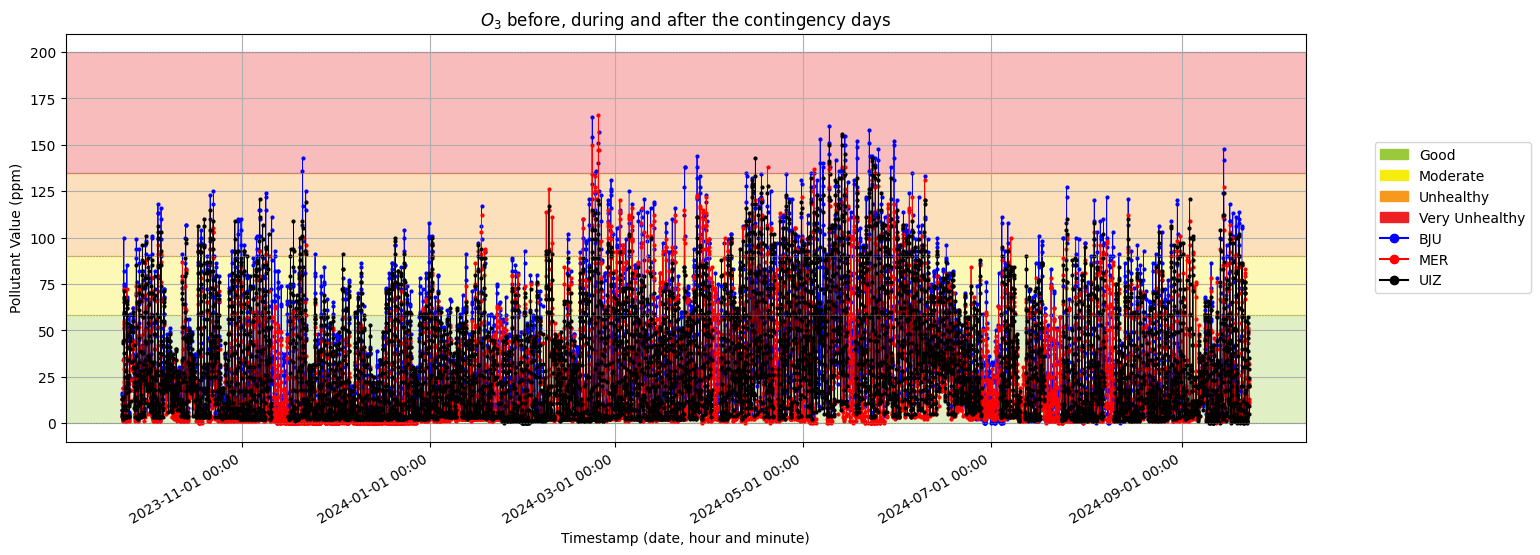

In [54]:
category_limits = [0, 58, 90, 135, 200]  #300
plot_pollutant(dates, dfs, category_limits, r"$O_3$", "ppm", dates_limits, stations)

# Interpolating the data

In [ ]:
#merged_df.interpolate(method='linear', inplace=True)
stations = ["BJU", "MER", "UIZ"] #  The "best" stations were we also have traffic data (from HERE) and doesn't have too many missing values (O3)

dfs = []
year = 2024
autumn = [f"{year-1}/09/23 00:00", f"{year-1}/12/20 23:00"]
winter = [f"{year-1}/12/21 00:00", f"{year}/03/19 23:00"]
spring = [f"{year}/03/20 00:00", f"{year}/06/20 23:00"]
summer = [f"{year}/06/21 00:00", f"{year}/09/22 23:00"]
seasons = {"winter":winter, "spring":spring, "summer":summer, "autumn":autumn}

#date_in = "2022-12-21"
date_in = autumn[0].replace("/", "-")
#date_end = "2024-12-20"
date_end = summer[1].replace("/", "-")
print(date_in, date_end)

category_limits = [0, 58, 90, 135, 200]  
date_in = "23/09/2023 00:00"
date_end = "22/09/2024 23:00"
date_in = datetime.strptime(date_in, "%d/%m/%Y %H:%M")
date_end = datetime.strptime(date_end, "%d/%m/%Y %H:%M")
datetime_list = pd.date_range(date_in, date_end, freq="h") 
dates= [dt.strftime("%Y-%m-%d %H:%M") for dt in datetime_list]
dates_limits = []

for station in stations:
	file_path = f"C:/Users/Valeria/Documents/CIC/air_pollution/graficas/{station}.csv"
	df  = pd.read_csv(file_path)
	df = df.drop_duplicates(subset='datetime_f', keep='first')
	print(station, df.datetime.min(), df.datetime.max())
	df = df.dropna(subset=['O3']).reset_index(drop=True)
	df = df.drop(columns=['datetime', 'NOX']) # NOX was dropped just because BJU doesnt have
	
	df['datetime_f']  = pd.to_datetime(df['datetime_f'] , format='%Y-%m-%d %H:%M:%S')
	datetime_list = pd.date_range(date_in, date_end, freq="h")  
	datetime_df = pd.DataFrame({"datetime_f": pd.to_datetime(datetime_list)})
	merged_df = datetime_df.merge(df, on="datetime_f", how="left")
	#merged_df.interpolate(method='linear', inplace=True)
	dfs.append(merged_df["O3"].tolist())

	print("len after the time cut",len(merged_df))
	print(merged_df.isnull().sum())
	#max_value = np.max([merged_df.isnull().sum()["TMP"], merged_df.isnull().sum()["RH"]])
	#max_value = np.max([merged_df.isnull().sum()["O3"]])
	print("% of missing values of O3", round(merged_df.isnull().sum()["O3"] / len(merged_df) *100.0,2), 
	   "TMP", round(merged_df.isnull().sum()["TMP"] / len(merged_df) *100.0,2), 
	   "RH", round(merged_df.isnull().sum()["RH"] / len(merged_df) *100.0,2))
	
	for season in seasons:
		date_in2 = datetime.strptime(seasons[season][0], "%Y/%m/%d %H:%M")
		date_end2 = datetime.strptime(seasons[season][1], "%Y/%m/%d %H:%M")
		df2 = df[df.datetime_f>=date_in2]
		df2 = df2[df2.datetime_f<=date_end2]
		df2 = df2.reset_index(drop=True)
		print("Season:", season, len(df2), "no. of rows to test:", round(len(df2)*.1, 2), "no. in days:", round(len(df2)*.1/24.0, 2))
		df_train, df_test = train_test_split(df2, test_size=0.1, random_state=42)  # 90-10 split
	print("\n")


	plot_pollutant(dates, [merged_df["O3"].tolist(), merged_df["TMP"].tolist(), merged_df["RH"].tolist()], category_limits, r"$O_3$", "ppm", dates_limits, [station, "TMP", "RH"])
	#break

NameError: name 'merged_df' is not defined

# Chosing meanwhile MER station because it has only 15.9% of missing data between RH, TMP and O3

2023-09-23 00:00 2024-09-22 23:00
MER 2005-01-01 00:00 2024-12-31 23:00
len after the time cut 120618
CO             6126
NO             5001
NOX            5001
NO2            5003
O3                0
PM10          14600
PM25          12299
RH                0
SO2            4321
TMP               0
WDR            1778
WSP            1983
datetime_f        0
hour              0
month             0
dtype: int64
% of missing values of O3 0.0 TMP 0.0 RH 0.0
Season: winter 1974 no. of rows to test: 197.4 no. in days: 8.22
Season: spring 2000 no. of rows to test: 200.0 no. in days: 8.33
Season: summer 2157 no. of rows to test: 215.7 no. in days: 8.99
Season: autumn 1254 no. of rows to test: 125.4 no. in days: 5.23




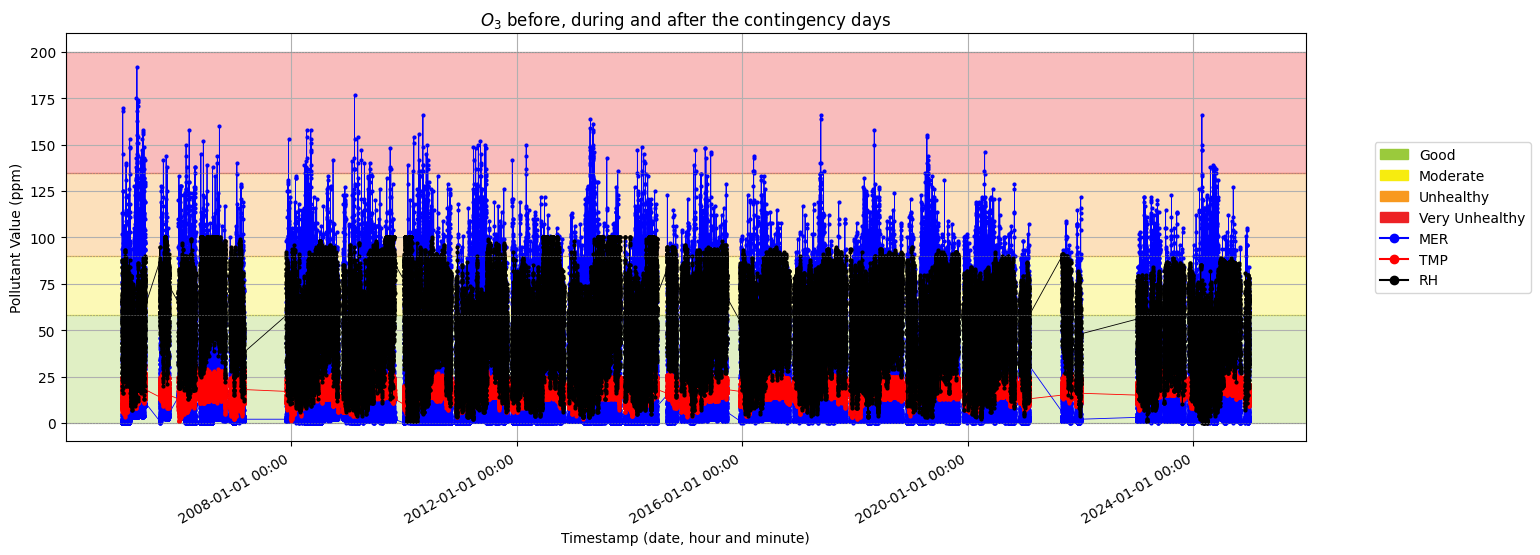

NameError: name 'norm_df' is not defined

In [12]:
stations = ["MER"] #  The "best" stations were we also have traffic data (from HERE) and doesn't have too many missing values (O3)

dfs = []
year = 2024
autumn = [f"{year-1}/09/23 00:00", f"{year-1}/12/20 23:00"]
winter = [f"{year-1}/12/21 00:00", f"{year}/03/19 23:00"]
spring = [f"{year}/03/20 00:00", f"{year}/06/20 23:00"]
summer = [f"{year}/06/21 00:00", f"{year}/09/22 23:00"]
seasons = {"winter":winter, "spring":spring, "summer":summer, "autumn":autumn}

#date_in = "2022-12-21"
date_in = autumn[0].replace("/", "-")
#date_end = "2024-12-20"
date_end = summer[1].replace("/", "-")
print(date_in, date_end)

category_limits = [0, 58, 90, 135, 200]  
date_in = "23/09/2023 00:00"
date_end = "22/09/2024 23:00"
date_in = datetime.strptime(date_in, "%d/%m/%Y %H:%M")
date_end = datetime.strptime(date_end, "%d/%m/%Y %H:%M")
datetime_list = pd.date_range(date_in, date_end, freq="h") 
dates= [dt.strftime("%Y-%m-%d %H:%M") for dt in datetime_list]
dates_limits = []

for station in stations:
	file_path = f"C:/Users/Valeria/Documents/CIC/air_pollution/graficas/{station}.csv"
	df  = pd.read_csv(file_path)
	df = df.drop_duplicates(subset='datetime_f', keep='first')
	print(station, df.datetime.min(), df.datetime.max())
	df = df.dropna(subset=['O3', 'TMP', 'RH']).reset_index(drop=True)
	df = df.drop(columns=['datetime']) # NOX was dropped just because BJU doesnt have

	dates = df.datetime_f.str[:-3]
	df['datetime_f']  = pd.to_datetime(df['datetime_f'] , format='%Y-%m-%d %H:%M:%S')
	df["hour"] = df.datetime_f.dt.hour
	df["month"] = df.datetime_f.dt.month
	datetime_list = pd.date_range(date_in, date_end, freq="h")  
	datetime_df = pd.DataFrame({"datetime_f": pd.to_datetime(datetime_list)})
	#merged_df = datetime_df.merge(df, on="datetime_f", how="left")
	merged_df = df
	#merged_df.interpolate(method='linear', inplace=True)
	dfs.append(merged_df["O3"].tolist())

	print("len after the time cut",len(merged_df))
	print(merged_df.isnull().sum())
	#max_value = np.max([merged_df.isnull().sum()["TMP"], merged_df.isnull().sum()["RH"]])
	#max_value = np.max([merged_df.isnull().sum()["O3"]])
	print("% of missing values of O3", round(merged_df.isnull().sum()["O3"] / len(merged_df) *100.0,2), 
	   "TMP", round(merged_df.isnull().sum()["TMP"] / len(merged_df) *100.0,2), 
	   "RH", round(merged_df.isnull().sum()["RH"] / len(merged_df) *100.0,2))
	
	for season in seasons:
		date_in2 = datetime.strptime(seasons[season][0], "%Y/%m/%d %H:%M")
		date_end2 = datetime.strptime(seasons[season][1], "%Y/%m/%d %H:%M")
		df2 = df[df.datetime_f>=date_in2]
		df2 = df2[df2.datetime_f<=date_end2]
		df2 = df2.reset_index(drop=True)
		print("Season:", season, len(df2), "no. of rows to test:", round(len(df2)*.1, 2), "no. in days:", round(len(df2)*.1/24.0, 2))
		df_train, df_test = train_test_split(df2, test_size=0.1, random_state=42)  # 90-10 split
	print("\n")

	plot_pollutant(dates, [merged_df["O3"].tolist(), merged_df["TMP"].tolist(), merged_df["RH"].tolist()], category_limits, r"$O_3$", "ppm", dates_limits, [station, "TMP", "RH"])
	df, scaler = norm_df(df)
	#"""
	corr = df.corr(numeric_only=True)
	plt.figure(figsize=(10,8))
	sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5, vmin=-1.0, vmax=1.0)
	plt.title(f"Correlation Matrix {station} studio")
	plt.show()
	#"""

In [18]:
import zipfile
from tensorflow import keras

with zipfile.ZipFile("autoencoder_model.keras.zip", "r") as zip_ref:
    zip_ref.extractall("autoencoder_model")

autoencoder = keras.models.load_model("autoencoder_model")

In [45]:
ini = 10000
df = df[ini:ini+3]

In [47]:
df

,CO,NO,NOX,NO2,O3,PM10,PM25,RH,SO2,TMP,WDR,WSP
16133,0.5,12.0,38.0,27.0,115.0,47.0,52.0,39.0,3.0,28.0,38.0,0.4
16134,0.6,9.0,41.0,32.0,117.0,78.0,32.0,33.0,2.0,27.0,167.0,0.5
16135,0.4,8.0,36.0,28.0,96.0,125.0,44.0,35.0,1.0,27.0,120.0,1.0


In [57]:
df_missing_clean

,CO,NO,NOX,NO2,O3,PM10,PM25,RH,SO2,TMP,WDR,WSP


In [58]:
df_missing

,datetime,CO,NO,NOX,NO2,O3,PM10,PM25,RH,SO2,TMP,WDR,WSP,datetime_f


In [ ]:
from tensorflow import keras
#df = merged_df
station = "MER"
file_path = f"C:/Users/Valeria/Documents/CIC/air_pollution/graficas/{station}.csv"
df  = pd.read_csv(file_path)
df = df.drop_duplicates(subset='datetime_f', keep='first')
df = df.drop(columns=['datetime','datetime_f'])
ini = 10000
df = df[ini:ini+3]
# Cargar las filas con NaN
df_missing = df[df.isnull().any(axis=1)]
# Eliminar columnas no numéricas antes de crear la máscara
# Crear la máscara de NaNs con las columnas ya limpias
nan_mask = df.isna().values
# Reemplazar NaNs con 0 solo en las columnas que se usan
df_filled = df.fillna(0)

scaler = MinMaxScaler()
# Normalizar
df_sample_scaled = pd.DataFrame(scaler.fit_transform(df_filled), columns=df.columns)
# Reconstrucción
reconstructed_data = autoencoder.predict(df_sample_scaled)
# Copiar los datos originales (ya normalizados con 0s)
data_recon = df_sample_scaled.copy().values
# Reemplazar solo donde había NaNs
data_recon[nan_mask] = reconstructed_data[nan_mask]
# Opcional: convertir a DataFrame
df_recon = pd.DataFrame(data_recon, columns=df.columns)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step


In [63]:
df_sample_scaled

,CO,NO,NOX,NO2,O3,PM10,PM25,RH,SO2,TMP,WDR,WSP
0,0.5,1.00,0.4,0.0,0.904762,0.000000,1.0,1.000000,1.0,1.0,0.000000,0.000000
1,1.0,0.25,1.0,1.0,1.000000,0.397436,0.0,0.000000,0.5,0.0,1.000000,0.166667
2,0.0,0.00,0.0,0.2,0.000000,1.000000,0.6,0.333333,0.0,0.0,0.635659,1.000000


In [60]:
df_recon

,CO,NO,NOX,NO2,O3,PM10,PM25,RH,SO2,TMP,WDR,WSP
0,0.5,1.00,0.4,0.0,0.904762,0.000000,1.0,1.000000,1.0,1.0,0.000000,0.000000
1,1.0,0.25,1.0,1.0,1.000000,0.397436,0.0,0.000000,0.5,0.0,1.000000,0.166667
2,0.0,0.00,0.0,0.2,0.000000,1.000000,0.6,0.333333,0.0,0.0,0.635659,1.000000


In [ ]:
"""
file_path = f"C:/Users/Valeria/Documents/CIC/air_pollution/graficas/{station}.csv"
df  = pd.read_csv(file_path)
df = df.drop_duplicates(subset='datetime_f', keep='first')
print(station, df.datetime.min(), df.datetime.max())
df = df.dropna(subset=['O3', 'TMP', 'RH']).reset_index(drop=True)
df = df.drop(columns=['datetime']) # NOX was dropped just because BJU doesnt have

dates = df.datetime_f.str[:-3]
df['datetime_f']  = pd.to_datetime(df['datetime_f'] , format='%Y-%m-%d %H:%M:%S')
df["hour"] = df.datetime_f.dt.hour
df["month"] = df.datetime_f.dt.month

df_bymonth_original = df.groupby('month').agg({
        'O3': 'mean',  
        'TMP': 'mean',  
    }).reset_index()
df_byhour_original = df.groupby('hour').agg({
        'O3': 'mean',  
        'TMP': 'mean', 
    }).reset_index()
#plot_values(df_bymonth_original,df_byhour_original, "month", "hour")

month_idx = {12:0, 10:1, 11:2, 1:3, 9:4, 7:5, 8:6, 2:7, 6:8, 3:9, 4:10, 5:11}
df_bymonth = df_bymonth_original.sort_values(by='O3', ascending=True)
df_bymonth["month_idx"] = df_bymonth["month"].map(month_idx)
hour_idx= {7:0, 6:1, 8:2, 5:3, 4:4, 3:5, 9:6, 2:7, 1:8, 0:9, 23:10, 22:11, 21:12, 10:13, 20:14, 19:15, 11:16, 18:17, 12:18, 17:19, 16:20, 13:21, 15:22, 14:23 }
df_byhour = df_byhour_original.sort_values(by='O3', ascending=True)
df_byhour["hour_idx"] = df_byhour["hour"].map(hour_idx)

#plot_values(df_bymonth,df_byhour, "month_idx", "hour_idx")
"""

MER 2005-01-01 00:00 2024-12-31 23:00


In [148]:
date_in2 = datetime.strptime(seasons["autumn"][0], "%Y/%m/%d %H:%M")
date_end2 = datetime.strptime(seasons["summer"][1], "%Y/%m/%d %H:%M")
df2 = df[df.datetime_f>=date_in2]
df2 = df2[df2.datetime_f<=date_end2]

In [149]:
df2

,CO,NO,NOX,NO2,O3,PM10,PM25,RH,SO2,TMP,WDR,WSP,datetime_f,month,hour
112251,0.067045,0.024896,0.074488,0.148148,0.015625,0.041311,0.075188,0.40,0.022124,0.606061,0.852778,0.318182,2023-09-23 00:00:00,0.363636,0.391304
112252,0.059091,0.014523,0.067039,0.153439,0.020833,0.045584,0.077694,0.60,0.004425,0.575758,0.869444,0.363636,2023-09-23 01:00:00,0.363636,0.347826
112253,0.050000,0.004149,0.037244,0.095238,0.067708,0.039886,0.072682,0.62,0.008850,0.545455,0.866667,0.318182,2023-09-23 02:00:00,0.363636,0.304348
112254,0.052273,0.002075,0.037244,0.100529,0.052083,0.034188,0.072682,0.65,0.017699,0.545455,0.005556,0.170455,2023-09-23 03:00:00,0.363636,0.217391
112255,0.053409,0.000000,0.037244,0.100529,0.046875,0.034188,0.075188,0.67,0.004425,0.545455,0.302778,0.056818,2023-09-23 04:00:00,0.363636,0.173913
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119631,0.059091,0.006224,0.029795,0.068783,0.109375,0.027066,0.070175,0.39,0.008850,0.727273,0.011111,0.477273,2024-09-22 19:00:00,0.363636,0.652174
119632,0.054545,0.004149,0.024209,0.058201,0.104167,0.035613,0.085213,0.46,0.004425,0.666667,0.033333,0.545455,2024-09-22 20:00:00,0.363636,0.608696
119633,0.061364,0.004149,0.031657,0.074074,0.067708,0.021368,0.057644,0.53,0.004425,0.636364,0.044444,0.363636,2024-09-22 21:00:00,0.363636,0.521739
119634,0.064773,0.004149,0.029795,0.068783,0.057292,0.037037,0.087719,0.63,0.004425,0.575758,0.002778,0.318182,2024-09-22 22:00:00,0.363636,0.478261


# 1 model for all the year (features: RH, TMP, hour of the day )